In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set up equations of motion and Euler integration

In [3]:
def euler_step(func, y, t, dt, params):
    return y + dt * func(y, t, params)

dt = 5e-3
M = 40 # Number of observation points
N = 200*M # Number of integration steps

observation_indices = np.arange(0, N+1, N//M)[1:] # first point is initial condition

def ode_solve(func, y0, t0, params, dt, N):
    ys = [y0]
    ts = [t0]
    y = y0
    t = t0
    for _ in range(N):
        y = euler_step(func, y, t, dt, params)
        ys.append(y)
        t += dt
        ts.append(t)
    return np.asarray(ys), ts

def vanderpol_func(y, t, mu):
    y1, y2 = y[0], y[1]
    dy1dt = y2
    dy2dt = mu * (1 - y1**2) * y2 - y1
    return np.asarray([dy1dt, dy2dt])

y_0 = np.asarray([2.0, 0.0])#, requires_grad=True)
mu = 1.

vanderpol_obs, vanderpol_times = ode_solve(vanderpol_func, y_0, 0.0, mu, dt, N)

In [4]:
print(observation_indices)
print(len(observation_indices), len(vanderpol_obs))

[ 200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800
 3000 3200 3400 3600 3800 4000 4200 4400 4600 4800 5000 5200 5400 5600
 5800 6000 6200 6400 6600 6800 7000 7200 7400 7600 7800 8000]
40 8001


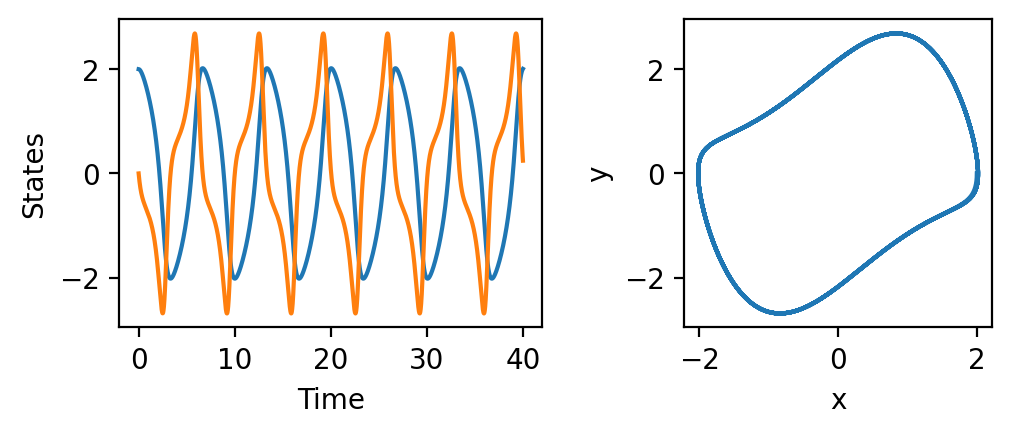

In [13]:
fig,ax=plt.subplots(1,2, figsize=(6,2),dpi=200)
ax[0].plot(vanderpol_times, vanderpol_obs[:, 0], label='y1')
ax[0].plot(vanderpol_times, vanderpol_obs[:, 1], label='y2')

ax[1].plot(vanderpol_obs[:, 0], vanderpol_obs[:, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('States')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_box_aspect(1)
#ax[0].legend()
#ax[1].legend()

## Set up adjoint equations of motion

In [6]:
initial_state = vanderpol_obs[0]
state_obs = vanderpol_obs[observation_indices]
print(len(state_obs))

# adjoint update rule
def adjoint_func(adj, y, forcing, t, dt, mu):
    adj0 = adj[0] - 2 * mu * y[0] * y[1] * adj[1] * dt + forcing[0]
    adj1 = adj[1] + (adj[0] + mu * (1 - y[0]**2) * adj[1]) * dt + forcing[1]
    return np.asarray([adj0, adj1])

def adjoint_solve(func, adj_init, y, forcing, mu, dt, N, M):
    """ Solve the adjoint equations backwards in time."""
    assert len(y)==N+1
    adjoints = []
    param_grad = []
    
    adj = adj_init
    for i in range(0, N):
        adj = adjoint_func(adj, y[N-i], forcing[N-i], 0.0, dt, mu)
        param_grad.append(adj[1] * (1 - y[N-i][0]**2) * y[N-i][1] * dt)
        adjoints.append(adj)

    return np.asarray(adjoints[::-1]), np.asarray(param_grad[::-1])



40


In [7]:
n_epochs = 1500
mu_param = 0.1
lr = 1e-1

epoch_to_save_adjoints = [0, n_epochs//2]

preds_hist = []
adjoints_hist = []
mu_hist = []

for epoch in range(n_epochs):
    # forward solve
    vanderpol_pred, _ = ode_solve(vanderpol_func, initial_state, 0.0, mu_param, dt, N)
    state_pred = vanderpol_pred[observation_indices]

    loss = np.mean((state_pred - state_obs)**2)

    # compute forcing
    forcing = np.zeros_like(vanderpol_pred)
    forcing[observation_indices] = 2.0 * (state_pred - state_obs) / M # forcing only happens at observation points

    # backward solve
    adjoints, param_grad = adjoint_solve(func=adjoint_func, 
                                         adj_init=forcing[-1],
                                         y=vanderpol_pred, 
                                         forcing=forcing, 
                                         mu=mu_param, 
                                         dt=dt, N=N, M=M)

    grad_mu = np.sum(param_grad)

    # update mu
    learning_rate = 1e-3
    mu_param = mu_param - learning_rate * grad_mu
    mu_hist.append(mu_param)

    if epoch % 50 == 0:
        print(f"Step {epoch}: Loss: {loss:0.2e}, mu: {mu_param:0.2e}, grad_mu: {grad_mu:0.2e}")

    if epoch in epoch_to_save_adjoints:
        preds_hist.append(vanderpol_pred)
        adjoints_hist.append(adjoints)
        

preds_hist = np.asarray(preds_hist)
adjoints_hist = np.asarray(adjoints_hist)
mu_hist = np.asarray(mu_hist)


Step 0: Loss: 4.06e+00, mu: 1.01e-01, grad_mu: -1.26e+00
Step 50: Loss: 3.88e+00, mu: 1.60e-01, grad_mu: -1.13e+00
Step 100: Loss: 3.70e+00, mu: 2.16e-01, grad_mu: -1.13e+00
Step 150: Loss: 3.50e+00, mu: 2.74e-01, grad_mu: -1.17e+00
Step 200: Loss: 3.26e+00, mu: 3.33e-01, grad_mu: -1.22e+00
Step 250: Loss: 2.98e+00, mu: 3.95e-01, grad_mu: -1.25e+00
Step 300: Loss: 2.68e+00, mu: 4.57e-01, grad_mu: -1.21e+00
Step 350: Loss: 2.36e+00, mu: 5.15e-01, grad_mu: -1.11e+00
Step 400: Loss: 2.07e+00, mu: 5.68e-01, grad_mu: -9.78e-01
Step 450: Loss: 1.82e+00, mu: 6.12e-01, grad_mu: -8.06e-01
Step 500: Loss: 1.61e+00, mu: 6.48e-01, grad_mu: -6.37e-01
Step 550: Loss: 1.45e+00, mu: 6.77e-01, grad_mu: -5.19e-01
Step 600: Loss: 1.31e+00, mu: 7.01e-01, grad_mu: -4.63e-01
Step 650: Loss: 1.18e+00, mu: 7.24e-01, grad_mu: -4.61e-01
Step 700: Loss: 1.04e+00, mu: 7.48e-01, grad_mu: -4.98e-01
Step 750: Loss: 8.88e-01, mu: 7.74e-01, grad_mu: -5.54e-01
Step 800: Loss: 7.21e-01, mu: 8.03e-01, grad_mu: -5.92e-01


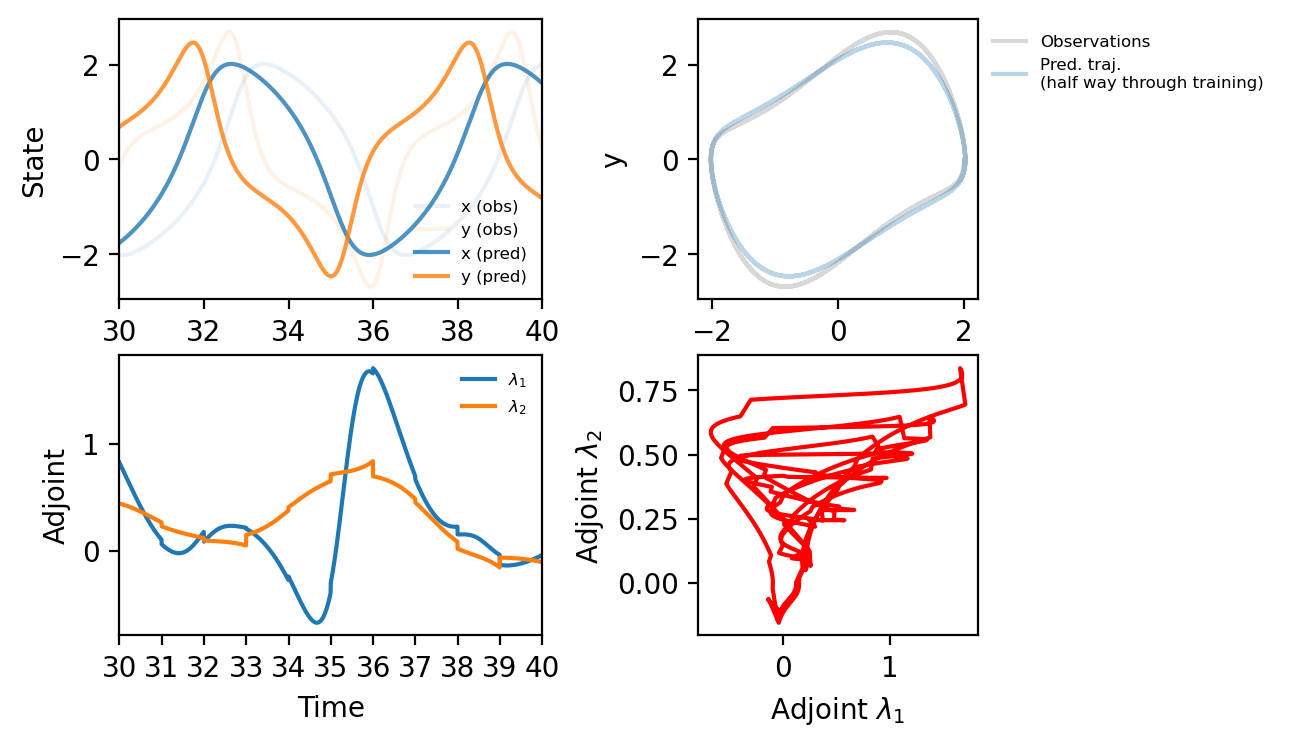

In [11]:
hist_idx_to_plot = 1 # 0 or 1
fig,ax=plt.subplots(2,2, figsize=(6,4),dpi=200)
ax[0][0].plot(vanderpol_times, vanderpol_obs[:, 0], label='x (obs)', color='C0', alpha=0.1)
ax[0][0].plot(vanderpol_times, vanderpol_obs[:, 1], label='y (obs)', color='C1', alpha=0.1)
ax[0][0].plot(vanderpol_times, preds_hist[hist_idx_to_plot][:, 0], label='x (pred)', color='C0', alpha=0.8)
ax[0][0].plot(vanderpol_times, preds_hist[hist_idx_to_plot][:, 1], label='y (pred)', color='C1', alpha=0.8)
ax[0][0].legend(frameon=False, fontsize=6)

ax[0][1].plot(vanderpol_obs[:, 0], vanderpol_obs[:, 1], color='gray', alpha=0.3, label='Observations')
ax[0][1].plot(preds_hist[hist_idx_to_plot][:, 0], preds_hist[hist_idx_to_plot][:, 1], color='C0', alpha=0.3, label='Pred. traj.\n(half way through training)')
ax[0][1].legend(frameon=False, fontsize=6, loc='upper left', bbox_to_anchor=(1,1))

ax[0][1].set_box_aspect(1)

# plot adjoints
ax[1][0].plot(vanderpol_times[:-1], adjoints_hist[hist_idx_to_plot][:, 0], label='$\\lambda_1$', color='C0')
ax[1][0].plot(vanderpol_times[:-1], adjoints_hist[hist_idx_to_plot][:, 1], label='$\\lambda_2$', color='C1')
ax[1][0].set_xticks(observation_indices * dt)
ax[1][0].legend(frameon=False, fontsize=6)

ax[1][1].plot(adjoints_hist[hist_idx_to_plot][:, 0], adjoints_hist[hist_idx_to_plot][:, 1], color='r')

for a in ax.T[0]:
    a.set_xlim(30, 40)

ax[0][0].set_ylabel('State')
ax[0][0].set_xlabel('Time')
ax[1][0].set_ylabel('Adjoint')
ax[1][0].set_xlabel('Time')
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('y')
ax[1][1].set_xlabel('Adjoint $\\lambda_1$')
ax[1][1].set_ylabel('Adjoint $\\lambda_2$')
ax[1][1].set_box_aspect(1)

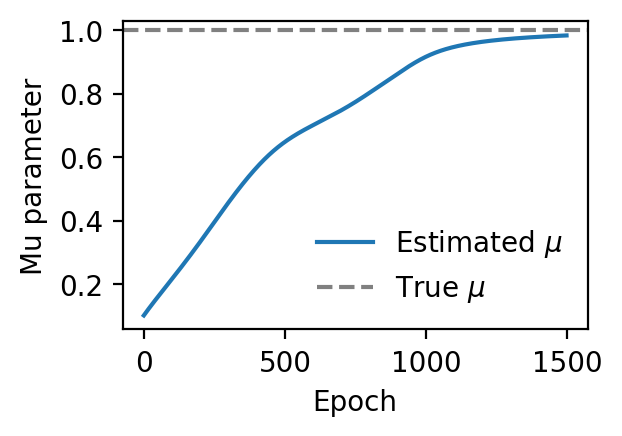

In [12]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)
ax.plot(mu_hist, label='Estimated $\\mu$')
ax.axhline(mu, color='gray', linestyle='--', label='True $\\mu$')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mu parameter')
ax.legend(frameon=False)